In [0]:
!pip install wordcloud
!pip install spacy
!python -m spacy download es_core_news_sm

from IPython.display import clear_output
clear_output()
print('WordCloud installed.')
print('Spacy es_core_news_model installed.\nRestart the runtime!')

WordCloud installed.
Spacy es_core_news_model installed.
Restart the runtime!


Go to Restart runtime...

In [1]:
import time
import requests


CUBADEBATE_API = "http://www.cubadebate.cu/wp-json/wp/v2/"
COMMENTS_ENDPOINT = CUBADEBATE_API + "comments/"

session = requests.Session()

def get_comments_json(page=1):
    params = {"page": str(page)}
    results = []
    
    with session:
        time.sleep(1)
        response = session.get(COMMENTS_ENDPOINT,
                               params=params)
        if response.status_code == 200:
            results = response.json()
            return results
    return results
        
comments_list = get_comments_json()
print(len(comments_list))
#comments_list

10


In [2]:
from concurrent.futures import ThreadPoolExecutor

NUM_PAGES=100

with ThreadPoolExecutor() as executor:
    results = executor.map(get_comments_json, range(1,NUM_PAGES+1))
    comments_list = list(results)
    
documents = [comment.get('content').get('rendered')
          for comments in comments_list
          for comment in comments]
        
print(len(documents))
#documents

1000


In [3]:
import re
import spacy

# Load model
nlp = spacy.load('es_core_news_sm')

def remplace_accents(text):
    """Remplace spanish accents vocab lower case: Unicode code point literal to str"""
    text = re.sub(r'á', 'a', text, flags=re.I)
    text = re.sub(r'é', 'e', text, flags=re.I)
    text = re.sub(r'í', 'i', text, flags=re.I)
    text = re.sub(r'ó', 'o', text, flags=re.I)
    text = re.sub(r'ú', 'u', text, flags=re.I)
    return text

def get_text(markup):
    """Remove html tags, URLs and spaces using regexp"""
    text = re.sub(r'<.*?>', '', markup)
    url_pattern = r'(http|ftp)s?://(?:[a-zA-Z]|\
                   [0-9]|[$-_@.&#+]|[!*\(\),]|\
                   (?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern,'', text)
    text = re.sub('\s+', ' ', text)
    return text.strip()

def clean(doc):
    """Remove grave accents, stopwords, the punctuations and normalize the corpus."""

    def is_token_allowed(token):
      """No Stop words, No Punctuations or len token >= 3"""
      if (not token or not token.string.strip() or
          token.is_stop or token.is_punct or len(token) < 3):
        return False
      return True

    def preprocess_token(token):
      """Remove grave accents and return token lower case"""
      result = remplace_accents(token.lemma_.strip().lower())
      return result

    text = get_text(doc)
    text = text.lower()
    tokens = [preprocess_token(word) for word in nlp(text)
              if is_token_allowed(word)]
    normalized = " ".join(word for word in tokens)
    return normalized
    

documents_normalized = [clean(doc).split() for doc in documents]
#documents_normalized
print('Documents normalized')


Documents normalized


In [4]:
import math
from collections import Counter


def comment_tf_dict(document):
    bow = Counter(document)
    tf_dict = dict()
    
    for k, v in bow.most_common():
        tf_dict[k] = v / len(document)
    
    return tf_dict

def comments_tf_dict(documents):
    return [comment_tf_dict(comment)
            for comment in documents]

def count_dict(documents):
    counts = dict()
    for document in documents:
        uniq_words = set(document)
        for word in uniq_words:
            value = counts.get(word, 0)
            counts[word] = value + 1
    return counts

def idf_dict(documents):
    idf_dict = dict()
    
    counts = count_dict(documents)
    
    for word in counts:
        idf_dict[word] = math.log(len(documents) / counts[word])
    
    return idf_dict

def comments_tfidf_dict(documents):
    tfidf_comments = []
    
    idf_comments = idf_dict(documents)
    
    def compute_tfidf_comment(document):
        tfidf_comment = dict()
        
        tf_comment = comment_tf_dict(document)
        
        for word in set(document):
            tfidf_comment[word] = tf_comment[word] * idf_comments[word]
        
        return tfidf_comment
    
    for comment in documents:
        tfidf_comments.append(compute_tfidf_comment(comment))
    
    
    return tfidf_comments


tfidf_list = comments_tfidf_dict(documents_normalized)
#tfidf_list
print('TF-IDF comments list')

TF-IDF comments list


In [5]:
import json
from collections import OrderedDict

ordered_tfidf = dict()

for tfidf in tfidf_list:
    for word, value in tfidf.items():
        if word in ordered_tfidf:
            ordered_tfidf[word] += value
        else:
            ordered_tfidf[word] = value

#ordered_tfidf
ordered_tfidf = OrderedDict(sorted(ordered_tfidf.items(), key=lambda x: x[1], reverse=True))
# Save to JSON file
with open('comments_tfidf.json', 'w') as file_json:
    json.dump(ordered_tfidf, file_json)
print('TF-IDF ordered saved to comments_tfidf.json')

TF-IDF ordered saved to comments_tfidf.json


In [6]:
import os

# Capitolio Habana
IMG_CAPITOLIO = os.getenv("IMG_CAPITOLIO") or "capitolio.jpg"

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
_dir = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

IMG_CAPITOLIO = os.path.join(_dir, IMG_CAPITOLIO)
IMG_CAPITOLIO_LINK = 'https://upload.wikimedia.org/wikipedia/commons/8/8f/Capitolio_full.jpg'

# download mask images
#!wget http://media.cubadebate.cu/wp-content/gallery/la-habana-nocturna/app_la-habana_05.jpg -O la_hababa.jpg
if not os.path.isfile(IMG_CAPITOLIO):
    response = requests.get(IMG_CAPITOLIO_LINK)

    if response.status_code == 200:
        with open(IMG_CAPITOLIO, 'wb') as _capitolio:
            _capitolio.write(response.content)
            print('Image downloaded.')
    else:
        print('Image No downloaded!')
else:
    image_downloaded = IMG_CAPITOLIO.split('\\')[-1].split('/')[-1]
    print(f"Image: {image_downloaded}")


Image: capitolio.jpg


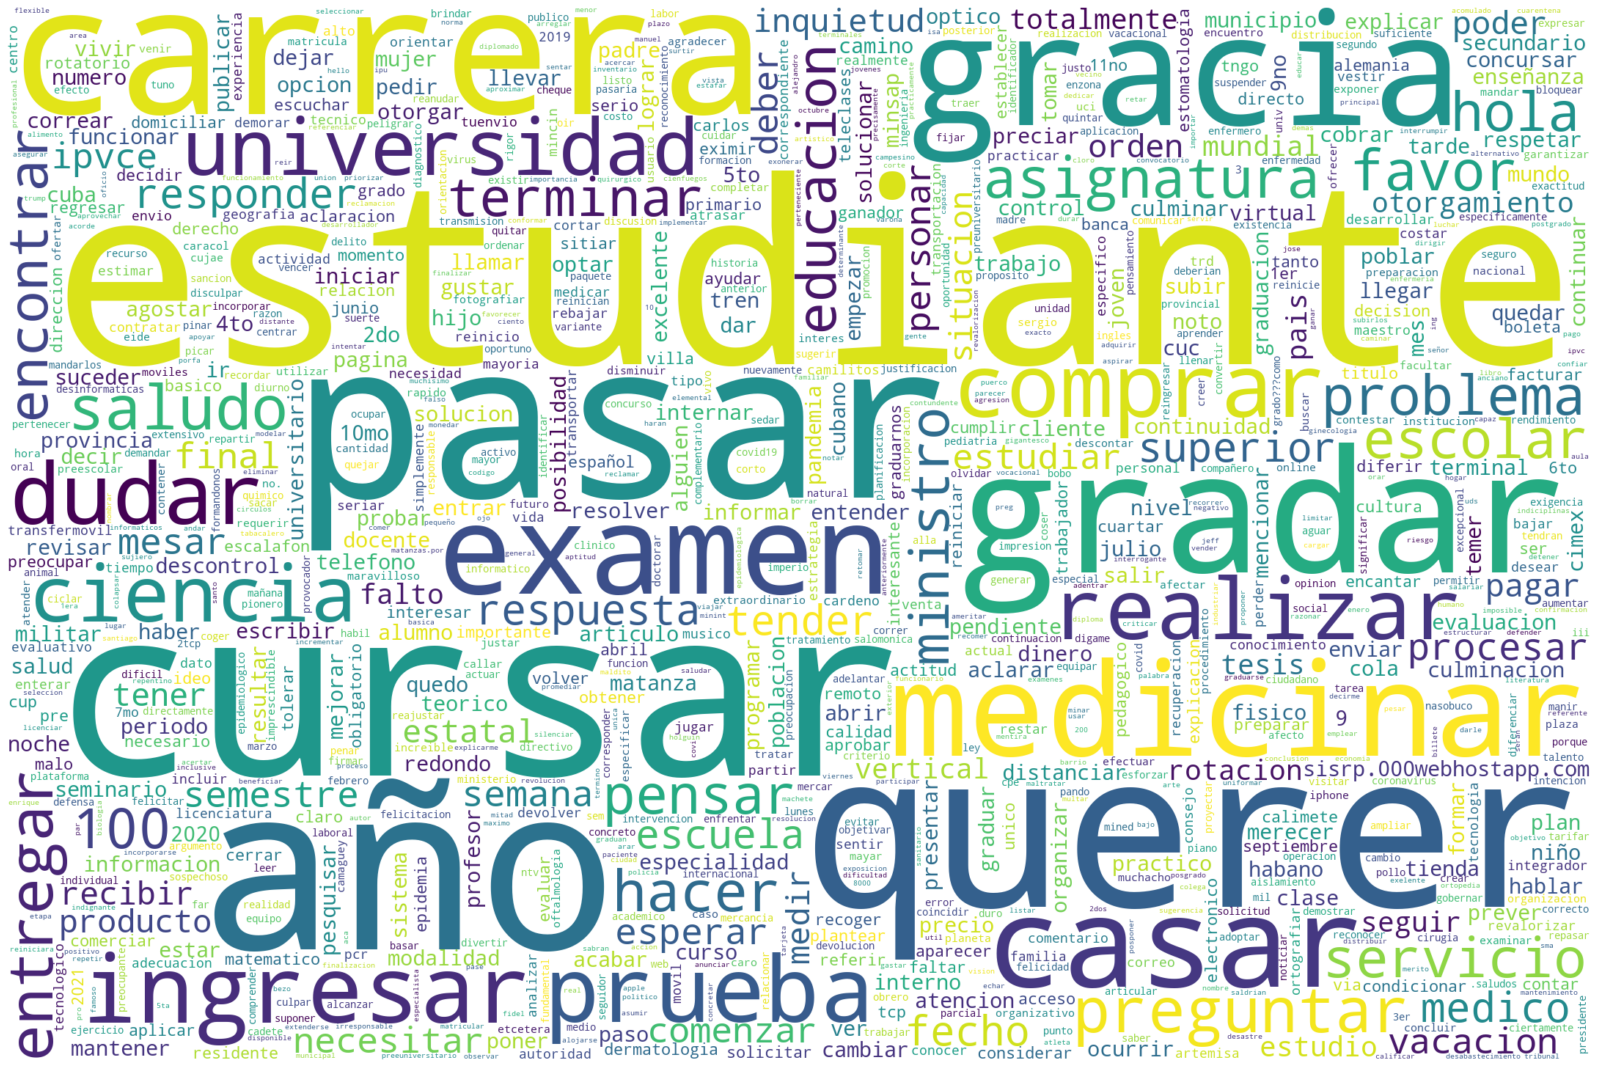

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from wordcloud import WordCloud

# WordsCloud Cubadebate
IMG_WORDCLOUD = 'wordcloud_cubadebate.png'
# Spacy Stop_Words
STOP_WORDS = spacy.lang.es.stop_words.STOP_WORDS

# read the mask image
_mask = np.array(Image.open(IMG_CAPITOLIO))

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=1000,
#     max_font_size=50,
    height=1440,
    width=2160,
    background_color = 'white',
    mask=_mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOP_WORDS).generate_from_frequencies(ordered_tfidf)
# Save to file
wordcloud.to_file(IMG_WORDCLOUD)
fig = plt.figure(
    figsize = (22, 15),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [8]:
import base64

data = ''
with open(IMG_WORDCLOUD, 'rb') as file_img:
    data = base64.b64encode(file_img.read()).decode('utf-8')

img_str = '''
<img width="100%" height="100%" 
src="data:image/png;base64,{}" />
'''.format(data)

with open('wordcloud_cubadebate.html', 'w') as _html:
    _html.write(img_str)

print('Exported image to html.')

Exported image to html.
